In [1]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load and explore the data
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/WORKSHOP/Failure Training.csv')
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (437760, 4)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437760 entries, 0 to 437759
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Timestamp    437760 non-null  object
 1   Temperature  437760 non-null  object
 2   Vibration    437760 non-null  object
 3   Activity     437760 non-null  object
dtypes: object(4)
memory usage: 13.4+ MB
None

First few rows:
       Timestamp  Temperature    Vibration Activity
0  1/1/2022 0:00  201.9849396  0.536977828  RUNNING
1  1/1/2022 0:01  201.9849396  0.546237111  RUNNING
2  1/1/2022 0:02  201.9849396  0.543806493  RUNNING
3  1/1/2022 0:03  200.9571075  0.541375935  RUNNING
4  1/1/2022 0:04  201.9849396   0.54498148  RUNNING


In [4]:
# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

print("Date Range:", df.index.min(), "to", df.index.max())
print("\nBasic Statistics:")
print(df.describe())

Date Range: 2022-01-01 00:00:00 to 2022-10-31 23:59:00

Basic Statistics:
        Temperature Vibration Activity
count        437760    437760   437760
unique        31610    137034        3
top     99.99977875         0  RUNNING
freq         105945    100605   314934


In [5]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Activity distribution
print("\nActivity Value Counts:")
print(df['Activity'].value_counts())


Missing Values:
Temperature    0
Vibration      0
Activity       0
dtype: int64

Activity Value Counts:
Activity
RUNNING      314934
STOPPED      122565
Bad Input       261
Name: count, dtype: int64


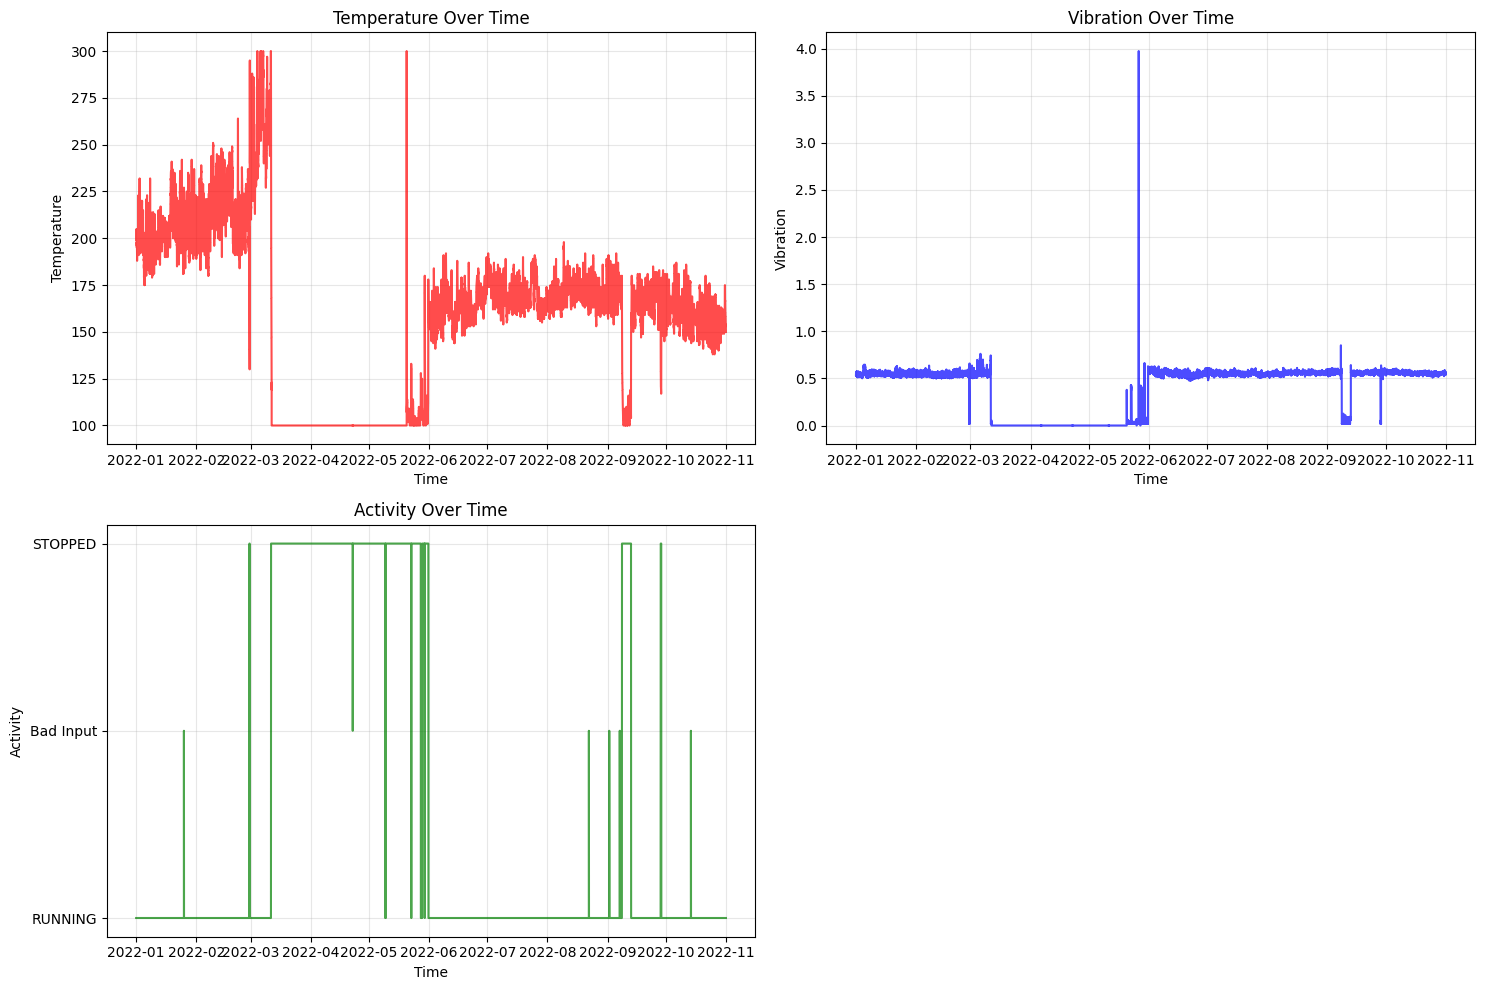

In [6]:
# Convert 'Temperature' and 'Vibration' to numeric, coercing errors
df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
df['Vibration'] = pd.to_numeric(df['Vibration'], errors='coerce')

# 1.1 Time Series Plots
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

# Temperature over time
plt.subplot(2, 2, 1)
plt.plot(df.index, df['Temperature'], color='red', alpha=0.7)
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.grid(True, alpha=0.3)

# Vibration over time
plt.subplot(2, 2, 2)
plt.plot(df.index, df['Vibration'], color='blue', alpha=0.7)
plt.title('Vibration Over Time')
plt.xlabel('Time')
plt.ylabel('Vibration')
plt.grid(True, alpha=0.3)

# Activity over time
plt.subplot(2, 2, 3)
# Plotting activity can be tricky due to its categorical nature over time.
# A simple approach is to visualize the raw data points, or consider a different plot type
# if analyzing the duration of each activity state.
# For now, let's plot the raw activity data points.
plt.plot(df.index, df['Activity'], color='green', alpha=0.7)
plt.title('Activity Over Time')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Missing Values after conversion:
Temperature    13
Vibration      22
Activity        0
dtype: int64


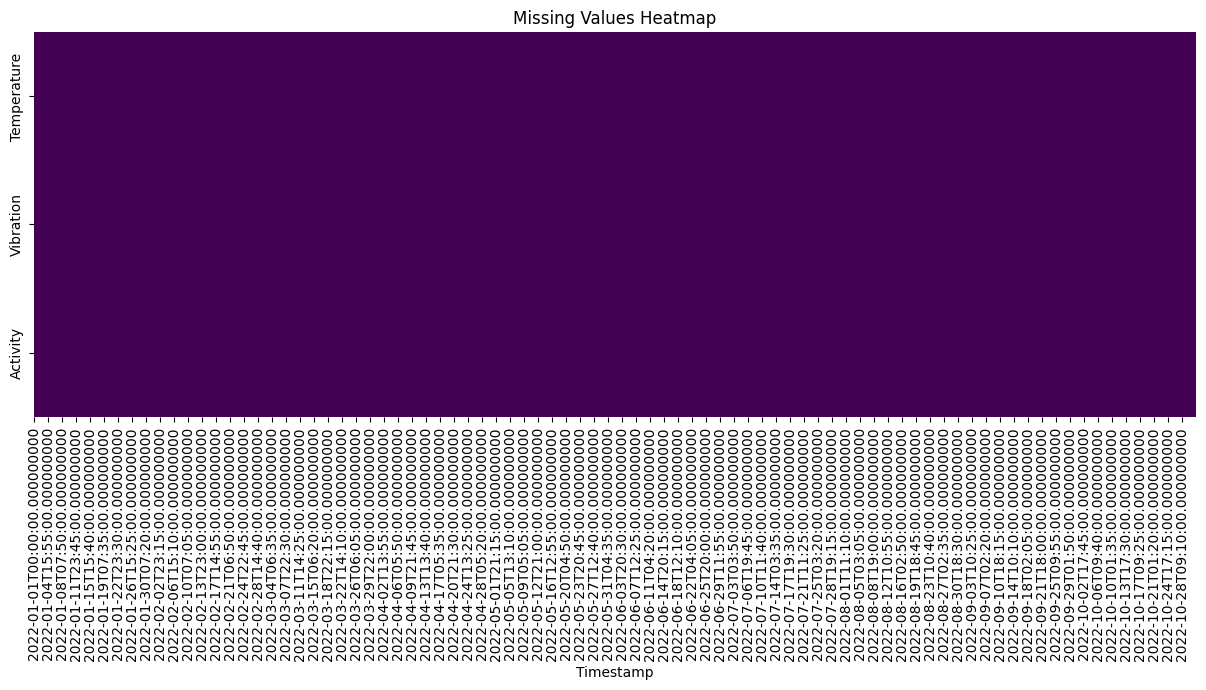

In [7]:
# 1.2 Handle Missing Values
print("\nMissing Values after conversion:")
print(df.isnull().sum())

# Visualize missing values (Optional but recommended)
plt.figure(figsize=(15, 5))
sns.heatmap(df.isnull().T, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

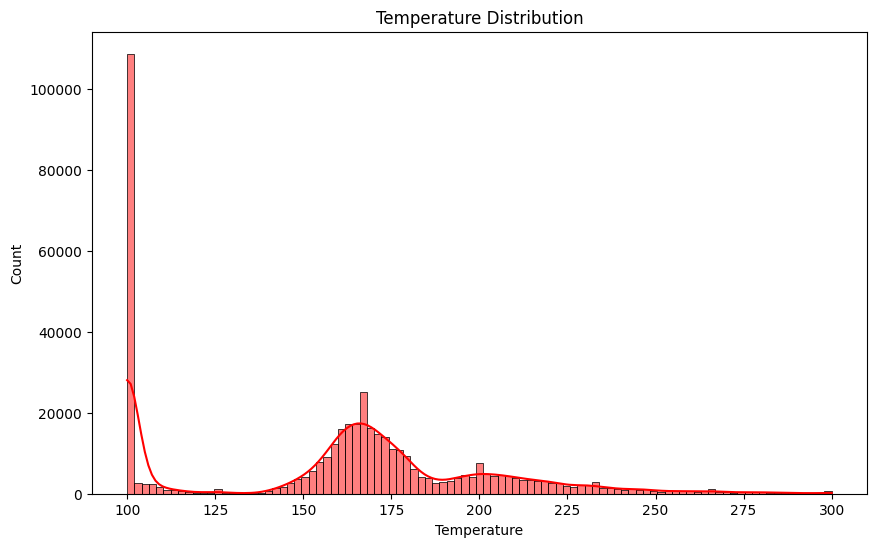

In [8]:
# Distribution plots
plt.figure(figsize=(10, 6)) # Added figure and figsize
plt.subplot(1, 1, 1) # Changed subplot to 1,1,1 since it's a single plot
sns.histplot(df['Temperature'], kde=True, color='red')
plt.title('Temperature Distribution')
plt.show() # Added show() to display the plot

Text(0.5, 1.0, 'Vibration Distribution')

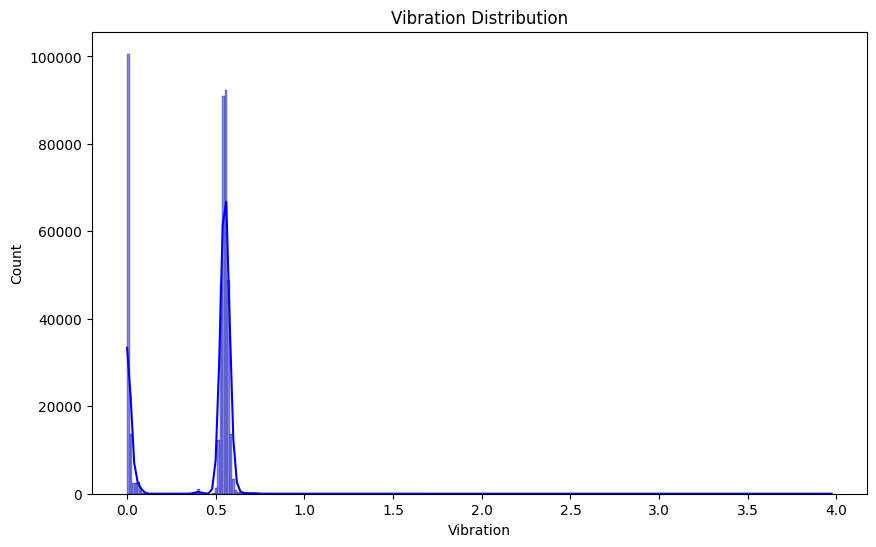

In [9]:
plt.figure(figsize=(10, 6)) # Added figure and figsize
plt.subplot(1, 1, 1) # Changed subplot to 1,1,1 since it's a single plot
sns.histplot(df['Vibration'], kde=True, color='blue')
plt.title('Vibration Distribution')

In [10]:
# 1.2 Correlation Analysis
import numpy as np
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

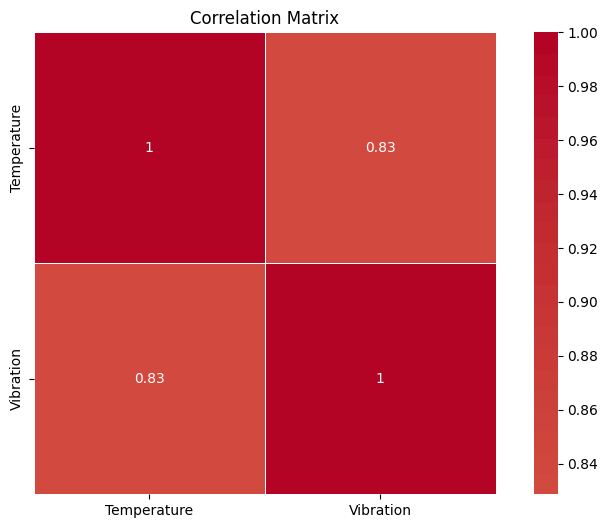

In [11]:
plt.figure(figsize=(10, 6)) # Added figure and figsize
plt.subplot(1, 1, 1) # Changed subplot to 1,1,1 since it's a single plot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

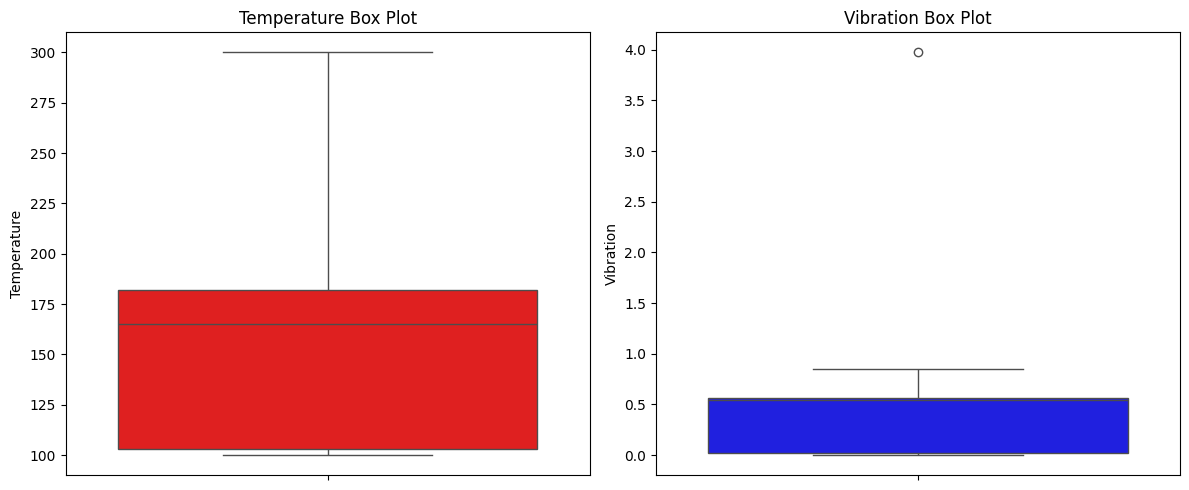

In [12]:
# 1.3 Box plots for outlier detection
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['Temperature'], color='red')
plt.title('Temperature Box Plot')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Vibration'], color='blue')
plt.title('Vibration Box Plot')

plt.tight_layout()
plt.show()

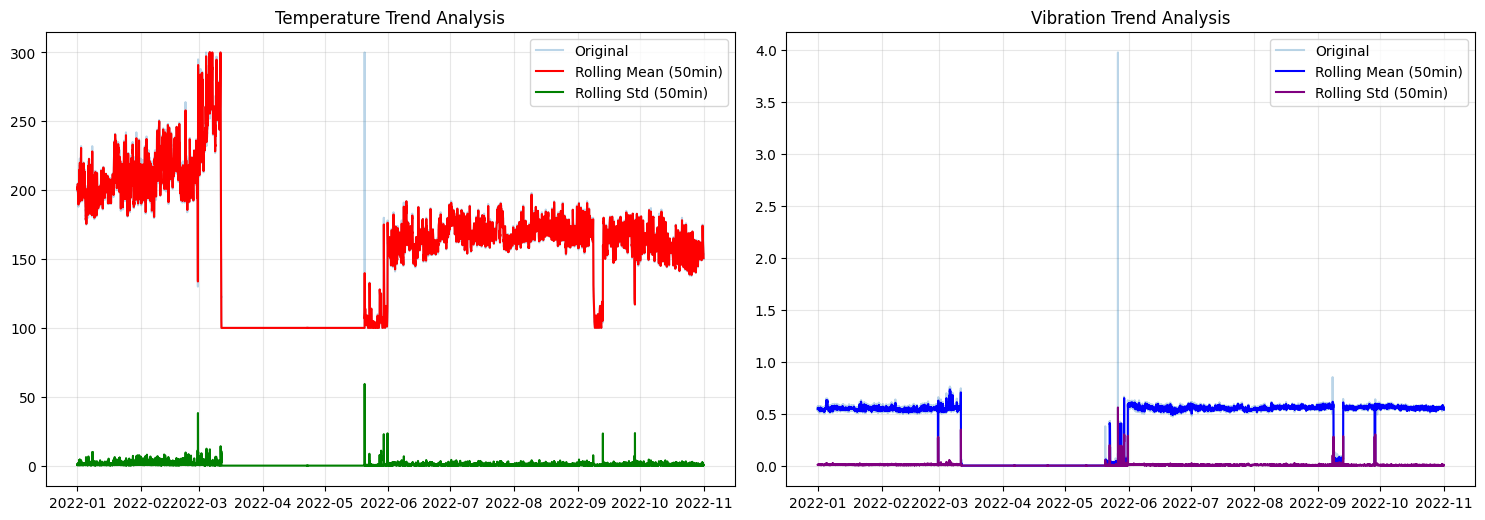

In [13]:
# 1.4 Rolling statistics for trend analysis
window_size = 50  # 50-minute rolling window

plt.figure(figsize=(15, 10))

# Temperature trends
plt.subplot(2, 2, 1)
rolling_mean_temp = df['Temperature'].rolling(window=window_size).mean()
rolling_std_temp = df['Temperature'].rolling(window=window_size).std()
plt.plot(df.index, df['Temperature'], alpha=0.3, label='Original')
plt.plot(df.index, rolling_mean_temp, label=f'Rolling Mean ({window_size}min)', color='red')
plt.plot(df.index, rolling_std_temp, label=f'Rolling Std ({window_size}min)', color='green')
plt.title('Temperature Trend Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

# Vibration trends
plt.subplot(2, 2, 2)
rolling_mean_vib = df['Vibration'].rolling(window=window_size).mean()
rolling_std_vib = df['Vibration'].rolling(window=window_size).std()
plt.plot(df.index, df['Vibration'], alpha=0.3, label='Original')
plt.plot(df.index, rolling_mean_vib, label=f'Rolling Mean ({window_size}min)', color='blue')
plt.plot(df.index, rolling_std_vib, label=f'Rolling Std ({window_size}min)', color='purple')
plt.title('Vibration Trend Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

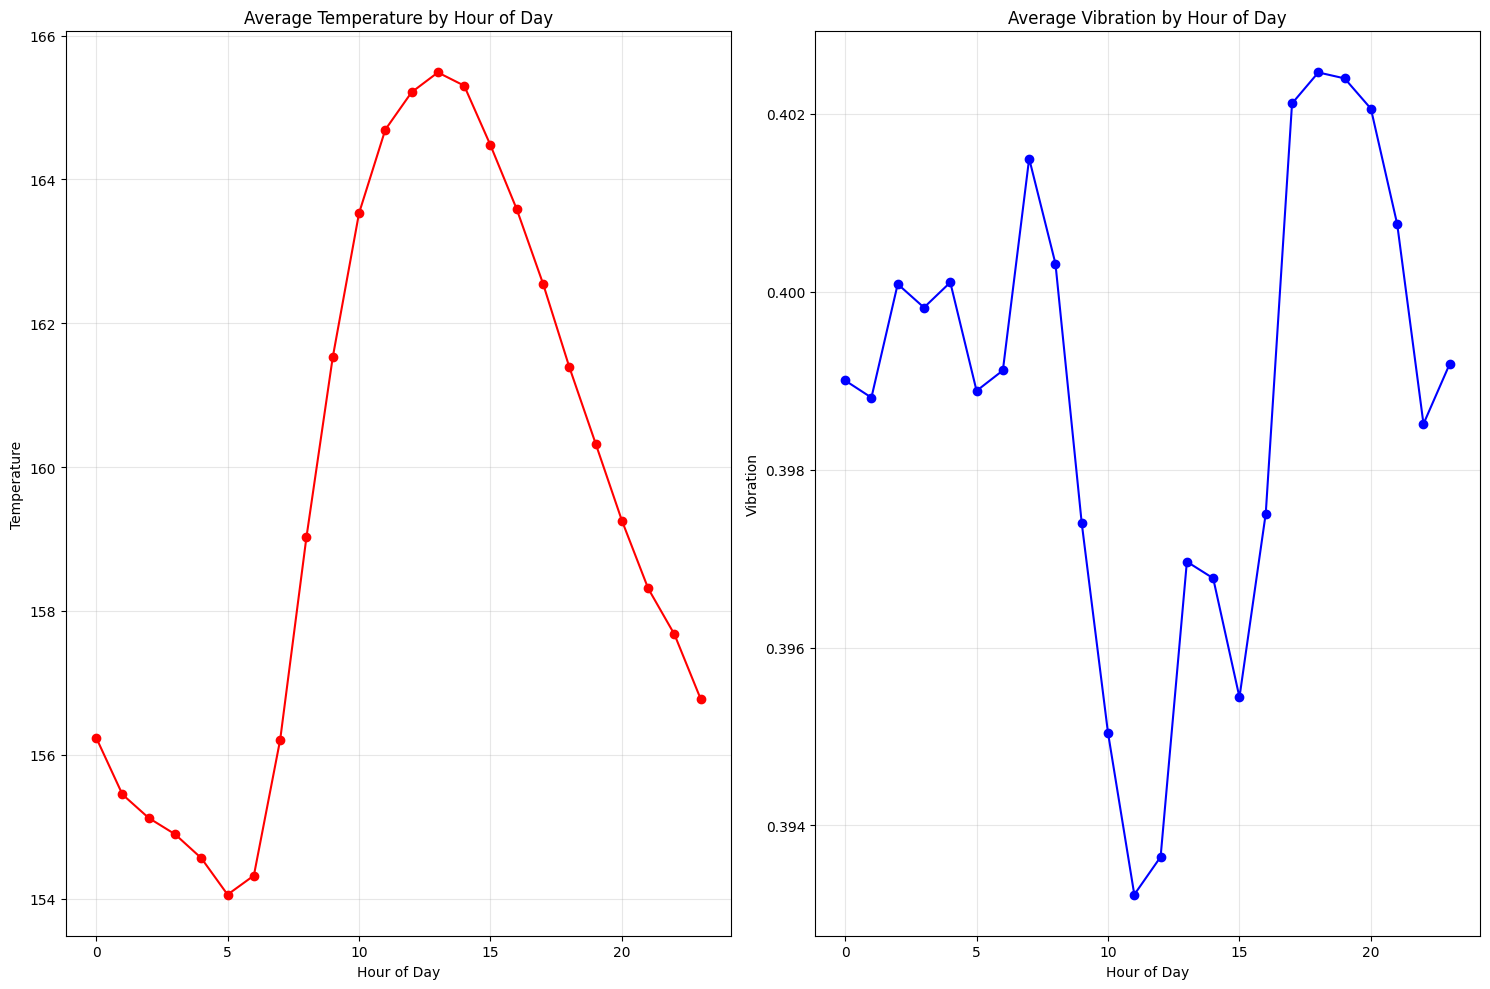

In [14]:
# Seasonal patterns (hourly)
plt.figure(figsize=(15, 10)) # Added figure and figsize
plt.subplot(1, 2, 1) # Changed subplot layout
hourly_temp = df.groupby(df.index.hour)['Temperature'].mean()
plt.plot(hourly_temp.index, hourly_temp.values, marker='o', color='red')
plt.title('Average Temperature by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2) # Changed subplot layout
hourly_vib = df.groupby(df.index.hour)['Vibration'].mean()
plt.plot(hourly_vib.index, hourly_vib.values, marker='o', color='blue')
plt.title('Average Vibration by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Vibration')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show() # Added show()

In [15]:
# Create time-based features
df_features = df.copy()
df_features['hour'] = df_features.index.hour
df_features['day_of_week'] = df_features.index.dayofweek
df_features['day_of_month'] = df_features.index.day
df_features['month'] = df_features.index.month

# Create lag features
df_features['temp_lag_1'] = df_features['Temperature'].shift(1)
df_features['vib_lag_1'] = df_features['Vibration'].shift(1)
df_features['temp_lag_5'] = df_features['Temperature'].shift(5)
df_features['vib_lag_5'] = df_features['Vibration'].shift(5)

# Create rolling statistics
df_features['temp_rolling_mean_6'] = df_features['Temperature'].rolling(window=6).mean()
df_features['vib_rolling_mean_6'] = df_features['Vibration'].rolling(window=6).mean()
df_features['temp_rolling_std_6'] = df_features['Temperature'].rolling(window=6).std()
df_features['vib_rolling_std_6'] = df_features['Vibration'].rolling(window=6).std()

# Remove rows with NaN values from lag features
df_features = df_features.dropna()

In [16]:
# Feature selection - correlation with target
# Drop the non-numeric 'Activity' column before calculating correlation
numeric_df_features = df_features.drop('Activity', axis=1)
target_correlation = numeric_df_features.corr()[['Temperature', 'Vibration']].abs().sort_values(by='Temperature', ascending=False)

print("Feature Correlation with Targets:")
print(target_correlation)

# Select top features for each target
top_temp_features = target_correlation['Temperature'].head(10).index.tolist()
top_vib_features = target_correlation['Vibration'].head(10).index.tolist()

print(f"\nTop features for Temperature prediction: {top_temp_features[:5]}")
print(f"Top features for Vibration prediction: {top_vib_features[:5]}")

# Prepare final feature set
selected_features = list(set(top_temp_features[:8] + top_vib_features[:8]))
if 'Temperature' in selected_features:
    selected_features.remove('Temperature')
if 'Vibration' in selected_features:
    selected_features.remove('Vibration')
if 'Activity' in selected_features:
    selected_features.remove('Activity')

print(f"\nFinal selected features: {selected_features}")

Feature Correlation with Targets:
                     Temperature  Vibration
Temperature             1.000000   0.828660
temp_rolling_mean_6     0.999927   0.828551
temp_lag_1              0.999912   0.828600
temp_lag_5              0.999795   0.828342
vib_rolling_mean_6      0.829162   0.999490
vib_lag_5               0.828895   0.998653
vib_lag_1               0.828713   0.999030
Vibration               0.828660   1.000000
vib_rolling_std_6       0.259107   0.243841
temp_rolling_std_6      0.253775   0.181307
month                   0.168241   0.263919
day_of_month            0.135758   0.069613
hour                    0.041092   0.001152
day_of_week             0.007074   0.002527

Top features for Temperature prediction: ['Temperature', 'temp_rolling_mean_6', 'temp_lag_1', 'temp_lag_5', 'vib_rolling_mean_6']
Top features for Vibration prediction: ['Temperature', 'temp_rolling_mean_6', 'temp_lag_1', 'temp_lag_5', 'vib_rolling_mean_6']

Final selected features: ['temp_lag_5', 'temp_

In [17]:
# Prepare data for LSTM
features_to_scale = selected_features + ['Temperature', 'Vibration']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_features[features_to_scale])

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    targets_temp = []
    targets_vib = []

    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length, :-2]  # All features except targets
        target_temp = data[i + sequence_length, -2]  # Temperature target
        target_vib = data[i + sequence_length, -1]   # Vibration target

        sequences.append(seq)
        targets_temp.append(target_temp)
        targets_vib.append(target_vib)

    return np.array(sequences), np.array(targets_temp), np.array(targets_vib)

In [18]:
SEQUENCE_LENGTH = 60  # Use 60 time steps to predict next step
X, y_temp, y_vib = create_sequences(scaled_data, SEQUENCE_LENGTH)

print(f"Sequences shape: {X.shape}")
print(f"Temperature targets shape: {y_temp.shape}")
print(f"Vibration targets shape: {y_vib.shape}")

# Split data into train/validation/test
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, X_temp = X[:train_size], X[train_size:]
y_temp_train, y_temp_temp = y_temp[:train_size], y_temp[train_size:]
y_vib_train, y_vib_temp = y_vib[:train_size], y_vib[train_size:]

X_val, X_test = X_temp[:val_size], X_temp[val_size:]
y_temp_val, y_temp_test = y_temp_temp[:val_size], y_temp_temp[val_size:]
y_vib_val, y_vib_test = y_vib_temp[:val_size], y_vib_temp[val_size:]

print(f"\nTrain set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Sequences shape: (437601, 60, 6)
Temperature targets shape: (437601,)
Vibration targets shape: (437601,)

Train set: (306320, 60, 6)
Validation set: (65640, 60, 6)
Test set: (65641, 60, 6)


In [19]:
def create_lstm_model(sequence_length, n_features):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(0.2),

        LSTM(64, return_sequences=True),
        Dropout(0.2),

        LSTM(32, return_sequences=False),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dropout(0.1),

        Dense(16, activation='relu'),
        Dense(2)  # Output: Temperature and Vibration
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model


In [20]:
# Create and display model
n_features = X.shape[2]
model = create_lstm_model(SEQUENCE_LENGTH, n_features)

print("Model Architecture:")
print(model.summary())

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.0001,
    verbose=1
)

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,562 (517.82 KB)

 Trainable params: 132,562 (517.82 KB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
# Combine targets for multi-output training
y_train_combined = np.column_stack([y_temp_train, y_vib_train])
y_val_combined = np.column_stack([y_temp_val, y_vib_val])
y_test_combined = np.column_stack([y_temp_test, y_vib_test])

# Train the model
history = model.fit(
    X_train, y_train_combined,
    validation_data=(X_val, y_val_combined),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
9573/9573 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - loss: 9.2915e-04 - mae: 0.0142 - val_loss: 2.8709e-05 - val_mae: 0.0038 - learning_rate: 0.0010
Epoch 2/30
9573/9573 ━━━━━━━━━━━━━━━━━━━━ 136s 14ms/step - loss: 1.0923e-04 - mae: 0.0059 - val_loss: 7.0680e-05 - val_mae: 0.0059 - learning_rate: 0.0010
Epoch 3/30
9573/9573 ━━━━━━━━━━━━━━━━━━━━ 132s 14ms/step - loss: 8.3474e-05 - mae: 0.0048 - val_loss: 4.4886e-05 - val_mae: 0.0046 - learning_rate: 0.0010
Epoch 4/30
9573/9573 ━━━━━━━━━━━━━━━━━━━━ 131s 14ms/step - loss: 7.0679e-05 - mae: 0.0043 - val_loss: 7.5419e-05 - val_mae: 0.0064 - learning_rate: 0.0010
Epoch 5/30
9573/9573 ━━━━━━━━━━━━━━━━━━━━ 132s 14ms/step - loss: 4.7393e-05 - mae: 0.0038 - val_loss: 6.6668e-05 - val_mae: 0.0061 - learning_rate: 0.0010
Epoch 6/30
9573/9573 ━━━━━━━━━━━━━━━━━━━━ 143s 14ms/step - loss: 4.5711e-05 - mae: 0.0037 - val_loss: 8.2196e-05 - val_mae: 0.0063 - learning_rate: 0.0010
Epoch 7/30
9573/9573 ━━━━━━━━━━━━━━━━━━━━ 134s 14ms/step - loss: 3.902

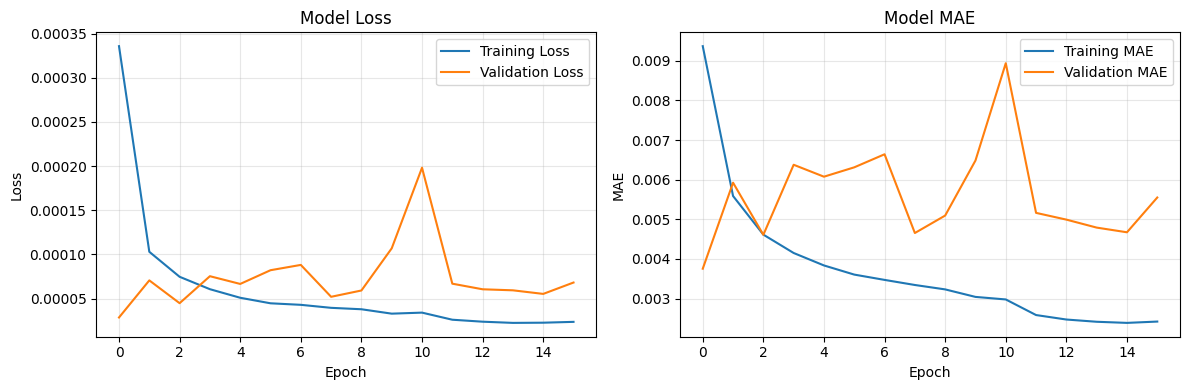

In [24]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

2052/2052 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

Temperature Prediction Metrics:
MSE: 0.000042
MAE: 0.005397
RMSE: 0.006499
R² Score: 0.9846

Vibration Prediction Metrics:
MSE: 0.000014
MAE: 0.002426
RMSE: 0.003733
R² Score: 0.9009


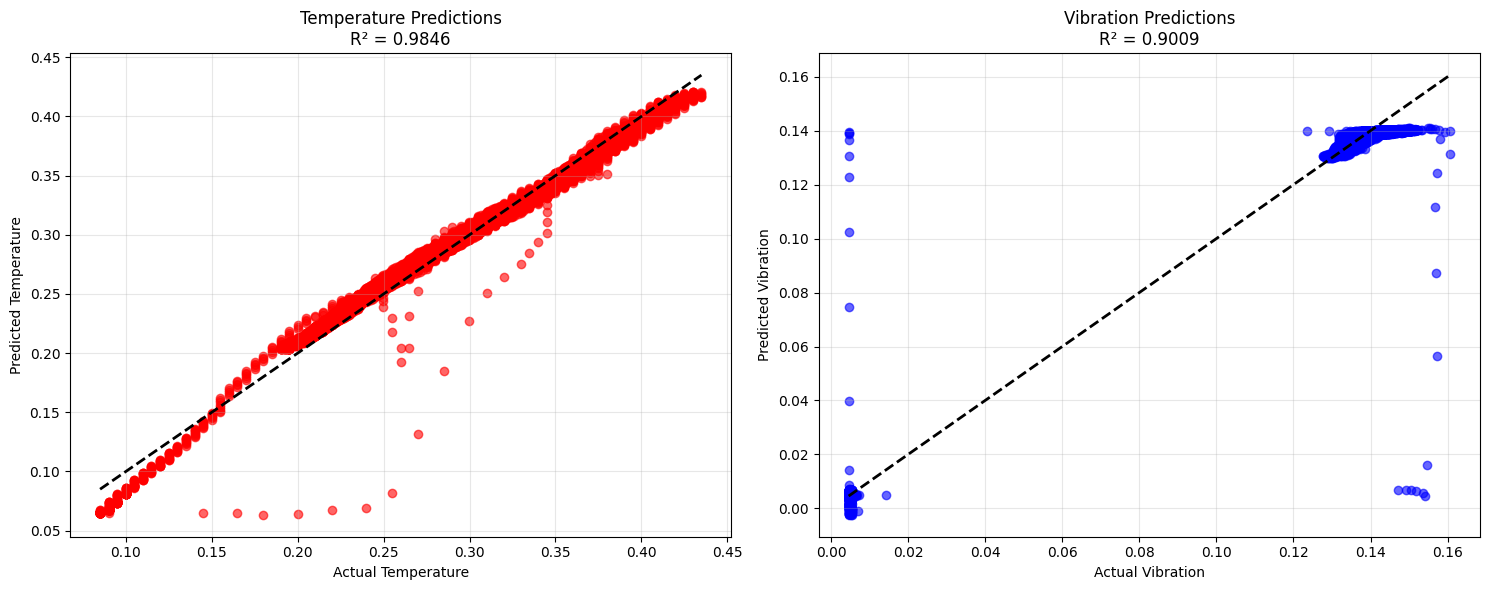

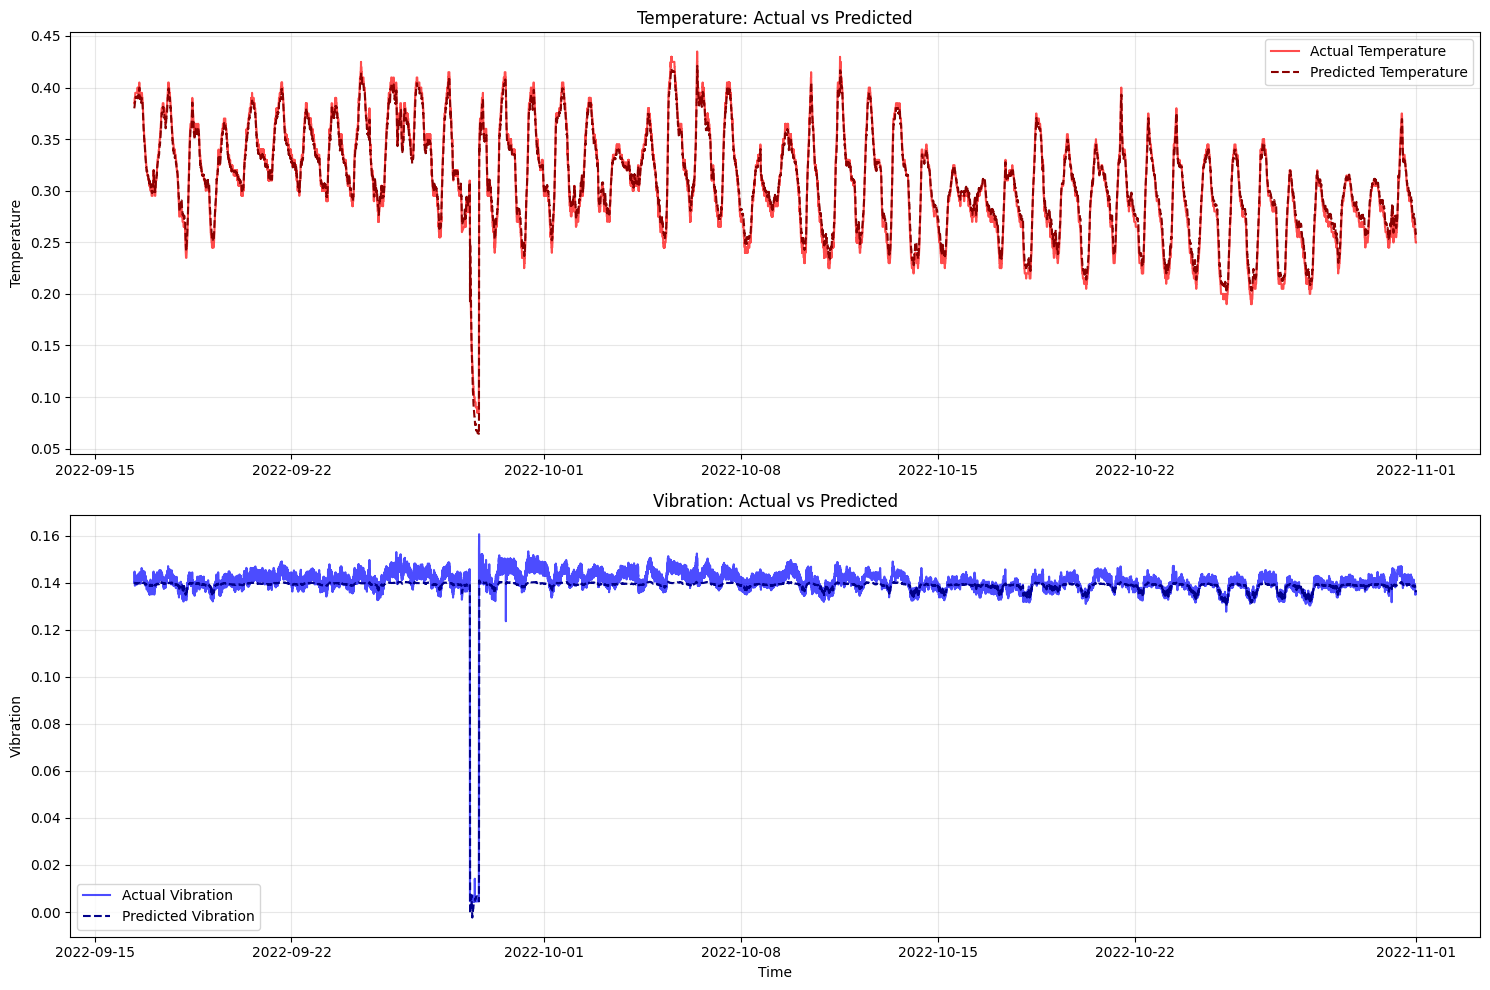

In [26]:
# =============================================================================
# 6. MODEL EVALUATION
# =============================================================================

# Make predictions
y_pred_combined = model.predict(X_test)
y_pred_temp = y_pred_combined[:, 0]
y_pred_vib = y_pred_combined[:, 1]

# Calculate metrics
def calculate_metrics(y_true, y_pred, target_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{target_name} Prediction Metrics:")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"R² Score: {r2:.4f}")

    return mse, mae, rmse, r2

# Temperature metrics
temp_metrics = calculate_metrics(y_temp_test, y_pred_temp, "Temperature")

# Vibration metrics
vib_metrics = calculate_metrics(y_vib_test, y_pred_vib, "Vibration")

# Plot predictions vs actual
plt.figure(figsize=(15, 6))

# Temperature predictions
plt.subplot(1, 2, 1)
plt.scatter(y_temp_test, y_pred_temp, alpha=0.6, color='red')
plt.plot([y_temp_test.min(), y_temp_test.max()], [y_temp_test.min(), y_temp_test.max()], 'k--', lw=2)
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title(f'Temperature Predictions\nR² = {temp_metrics[3]:.4f}')
plt.grid(True, alpha=0.3)

# Vibration predictions
plt.subplot(1, 2, 2)
plt.scatter(y_vib_test, y_pred_vib, alpha=0.6, color='blue')
plt.plot([y_vib_test.min(), y_vib_test.max()], [y_vib_test.min(), y_vib_test.max()], 'k--', lw=2)
plt.xlabel('Actual Vibration')
plt.ylabel('Predicted Vibration')
plt.title(f'Vibration Predictions\nR² = {vib_metrics[3]:.4f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Time series comparison
test_dates = df_features.index[-len(y_temp_test):]

plt.figure(figsize=(15, 10))

# Temperature time series
plt.subplot(2, 1, 1)
plt.plot(test_dates, y_temp_test, label='Actual Temperature', color='red', alpha=0.7)
plt.plot(test_dates, y_pred_temp, label='Predicted Temperature', color='darkred', linestyle='--')
plt.title('Temperature: Actual vs Predicted')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True, alpha=0.3)

# Vibration time series
plt.subplot(2, 1, 2)
plt.plot(test_dates, y_vib_test, label='Actual Vibration', color='blue', alpha=0.7)
plt.plot(test_dates, y_pred_vib, label='Predicted Vibration', color='darkblue', linestyle='--')
plt.title('Vibration: Actual vs Predicted')
plt.ylabel('Vibration')
plt.xlabel('Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

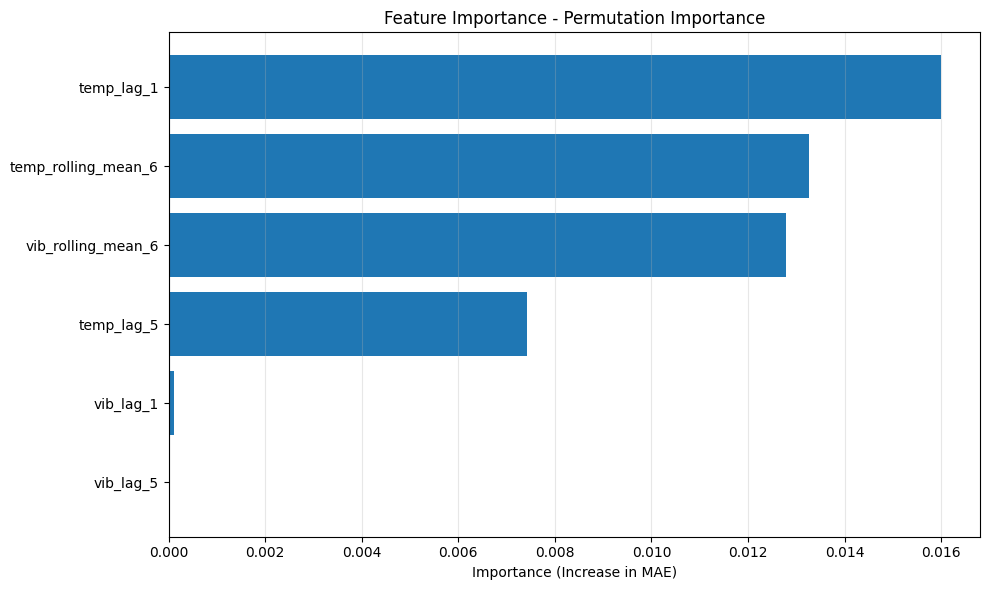


Top 5 Most Important Features:
               Feature  Importance
2            vib_lag_1    0.000117
0           temp_lag_5    0.007419
3   vib_rolling_mean_6    0.012778
1  temp_rolling_mean_6    0.013256
5           temp_lag_1    0.016003


In [28]:
# =============================================================================
# 7. FEATURE IMPORTANCE ANALYSIS
# =============================================================================

# Analyze feature importance using permutation importance
def permutation_importance(model, X_val, y_val, feature_names, n_iterations=10):
    baseline_score = model.evaluate(X_val, y_val, verbose=0)[1]  # MAE

    importance_scores = []

    for feature_idx in range(X_val.shape[2]):
        X_val_permuted = X_val.copy()
        original_feature = X_val_permuted[:, :, feature_idx].copy()

        permutation_scores = []

        for _ in range(n_iterations):
            # Permute the feature
            X_val_permuted[:, :, feature_idx] = np.random.permutation(original_feature)

            # Calculate score with permuted feature
            permuted_score = model.evaluate(X_val_permuted, y_val, verbose=0)[1]
            permutation_scores.append(permuted_score)

            # Reset to original
            X_val_permuted[:, :, feature_idx] = original_feature

        avg_permuted_score = np.mean(permutation_scores)
        importance = avg_permuted_score - baseline_score
        importance_scores.append(importance)

    return importance_scores

feature_names = selected_features
importance_scores = permutation_importance(model, X_val, y_val_combined, feature_names)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
}).sort_values('Importance', ascending=True)

plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance (Increase in MAE)')
plt.title('Feature Importance - Permutation Importance')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance_df.tail(5))

100 Steps

Future Predictions Sample (first 10 steps):
   Predicted_Temperature  Predicted_Vibration
0             151.646633             0.543624
1             151.088701             0.543364
2             149.768386             0.541989
3             147.785056             0.539163
4             145.440781             0.535152
5             143.321425             0.529936
6             142.117752             0.523154
7             141.235808             0.518262
8             140.734855             0.515746
9             140.593935             0.515569


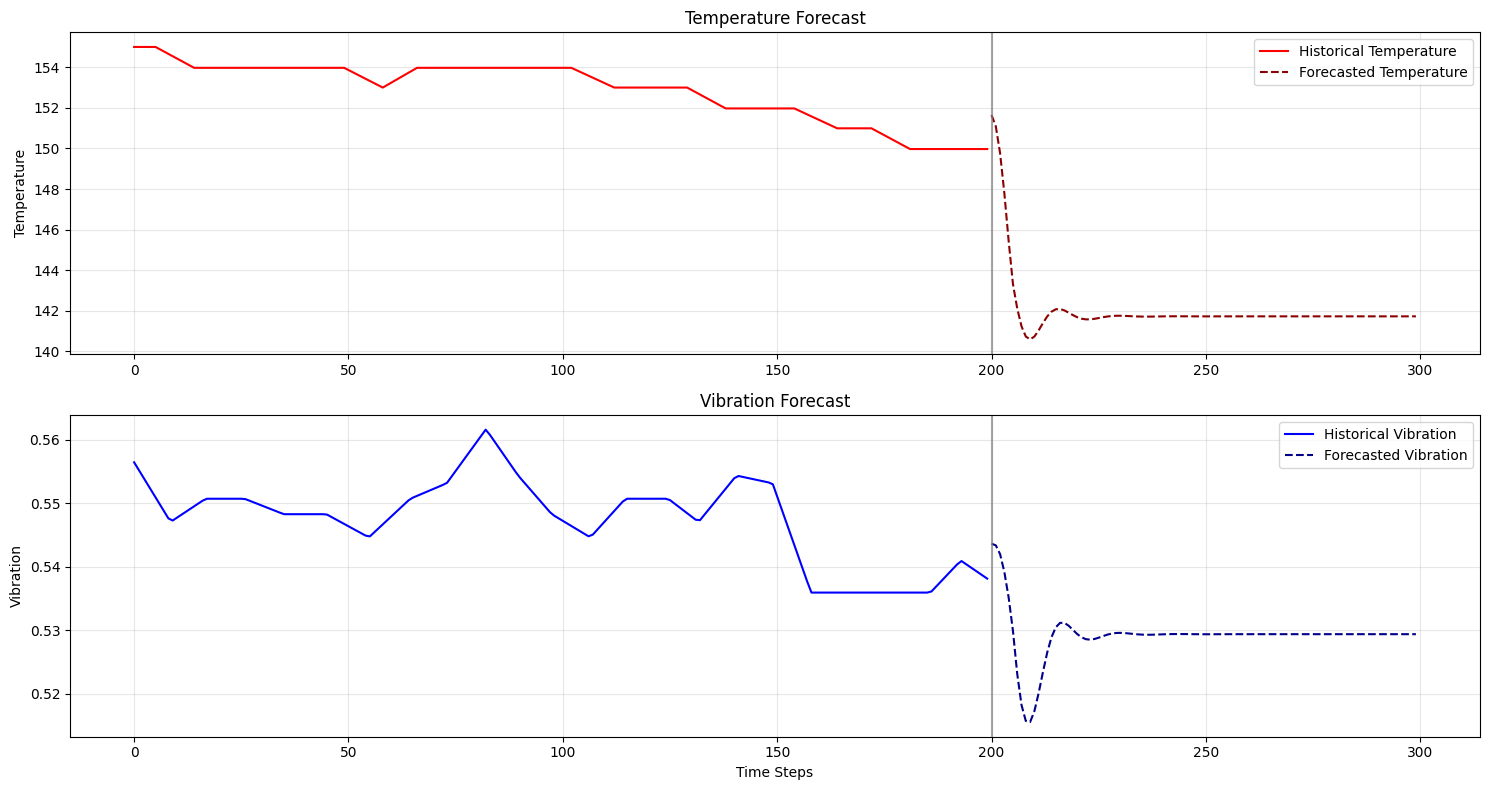

In [32]:
# =============================================================================
# 8. FUTURE FORECASTING
# =============================================================================

def forecast_future(model, last_sequence, n_steps, scaler, feature_indices):
    """
    Forecast future values
    """
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        # Predict next step
        next_pred = model.predict(current_sequence.reshape(1, SEQUENCE_LENGTH, -1), verbose=0)[0]
        future_predictions.append(next_pred)

        # Update sequence for next prediction
        new_row = current_sequence[-1].copy()

        # Update features (this is simplified - in practice you'd need to update all engineered features)
        new_row[feature_indices['temp_idx']] = next_pred[0]
        new_row[feature_indices['vib_idx']] = next_pred[1]

        current_sequence = np.vstack([current_sequence[1:], new_row])

    return np.array(future_predictions)

# Prepare for forecasting
last_sequence = scaled_data[-SEQUENCE_LENGTH:, :-2]  # Last sequence without targets

# Get feature indices (you would need to map these properly)
feature_indices = {
    'temp_idx': features_to_scale.index('Temperature') - 2,  # Adjust for target columns
    'vib_idx': features_to_scale.index('Vibration') - 2
}

# Forecast next 100 steps
n_future_steps = 100
future_predictions = forecast_future(model, last_sequence, n_future_steps, scaler, feature_indices)

# Inverse transform predictions
dummy_array = np.zeros((n_future_steps, len(features_to_scale)))
dummy_array[:, -2] = future_predictions[:, 0]  # Temperature predictions
dummy_array[:, -1] = future_predictions[:, 1]   # Vibration predictions

future_predictions_inv = scaler.inverse_transform(dummy_array)[:, -2:]

print("Future Predictions Sample (first 10 steps):")
future_df = pd.DataFrame({
    'Predicted_Temperature': future_predictions_inv[:, 0],
    'Predicted_Vibration': future_predictions_inv[:, 1]
})
print(future_df.head(10))

# Plot future forecasts
plt.figure(figsize=(15, 8))

# Temperature forecast
plt.subplot(2, 1, 1)
historical_temp = df['Temperature'].values[-200:]  # Last 200 points
future_temp = future_predictions_inv[:, 0]

plt.plot(range(len(historical_temp)), historical_temp, label='Historical Temperature', color='red')
plt.plot(range(len(historical_temp), len(historical_temp) + len(future_temp)),
         future_temp, label='Forecasted Temperature', color='darkred', linestyle='--')
plt.axvline(x=len(historical_temp), color='gray', linestyle='-', alpha=0.7)
plt.ylabel('Temperature')
plt.title('Temperature Forecast')
plt.legend()
plt.grid(True, alpha=0.3)

# Vibration forecast
plt.subplot(2, 1, 2)
historical_vib = df['Vibration'].values[-200:]
future_vib = future_predictions_inv[:, 1]

plt.plot(range(len(historical_vib)), historical_vib, label='Historical Vibration', color='blue')
plt.plot(range(len(historical_vib), len(historical_vib) + len(future_vib)),
         future_vib, label='Forecasted Vibration', color='darkblue', linestyle='--')
plt.axvline(x=len(historical_vib), color='gray', linestyle='-', alpha=0.7)
plt.ylabel('Vibration')
plt.xlabel('Time Steps')
plt.title('Vibration Forecast')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
# =============================================================================
# 9. MODEL DEPLOYMENT PREPARATION
# =============================================================================

# Save the model
model.save('motor_sensor_lstm_model.h5')

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')

# Save feature names
feature_info = {
    'selected_features': selected_features,
    'sequence_length': SEQUENCE_LENGTH,
    'features_to_scale': features_to_scale
}

import json
with open('model_features.json', 'w') as f:
    json.dump(feature_info, f)

print("Model and preprocessing artifacts saved successfully!")
print(f"Final Model Performance Summary:")
print(f"Temperature R²: {temp_metrics[3]:.4f}")
print(f"Vibration R²: {vib_metrics[3]:.4f}")
print(f"Average MAE - Temperature: {temp_metrics[1]:.4f}")
print(f"Average MAE - Vibration: {vib_metrics[1]:.4f}")

# Create performance summary
performance_summary = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'R²'],
    'Temperature': [f"{temp_metrics[0]:.6f}", f"{temp_metrics[1]:.6f}",
                   f"{temp_metrics[2]:.6f}", f"{temp_metrics[3]:.4f}"],
    'Vibration': [f"{vib_metrics[0]:.6f}", f"{vib_metrics[1]:.6f}",
                 f"{vib_metrics[2]:.6f}", f"{vib_metrics[3]:.4f}"]
})

print("\nPerformance Summary:")
print(performance_summary)

Model and preprocessing artifacts saved successfully!
Final Model Performance Summary:
Temperature R²: 0.9846
Vibration R²: 0.9009
Average MAE - Temperature: 0.0054
Average MAE - Vibration: 0.0024

Performance Summary:
  Metric Temperature Vibration
0    MSE    0.000042  0.000014
1    MAE    0.005397  0.002426
2   RMSE    0.006499  0.003733
3     R²      0.9846    0.9009


In [42]:
# =============================================================================
# 10. MODEL OUTPUT
# =============================================================================

print("All Future Predictions with Timestamp:")
display(future_df)

All Future Predictions with Timestamp:


,Predicted_Temperature,Predicted_Vibration
0,151.646633,0.543624
1,151.088701,0.543364
2,149.768386,0.541989
3,147.785056,0.539163
4,145.440781,0.535152
...,...,...
87835,141.728094,0.529395
87836,141.728094,0.529395
87837,141.728094,0.529395
87838,141.728094,0.529395


87840 Steps

Future Predictions Sample (first 10 steps):
   Predicted_Temperature  Predicted_Vibration
0             151.646633             0.543624
1             151.088701             0.543364
2             149.768386             0.541989
3             147.785056             0.539163
4             145.440781             0.535152
5             143.321425             0.529936
6             142.117752             0.523154
7             141.235808             0.518262
8             140.734855             0.515746
9             140.593935             0.515569


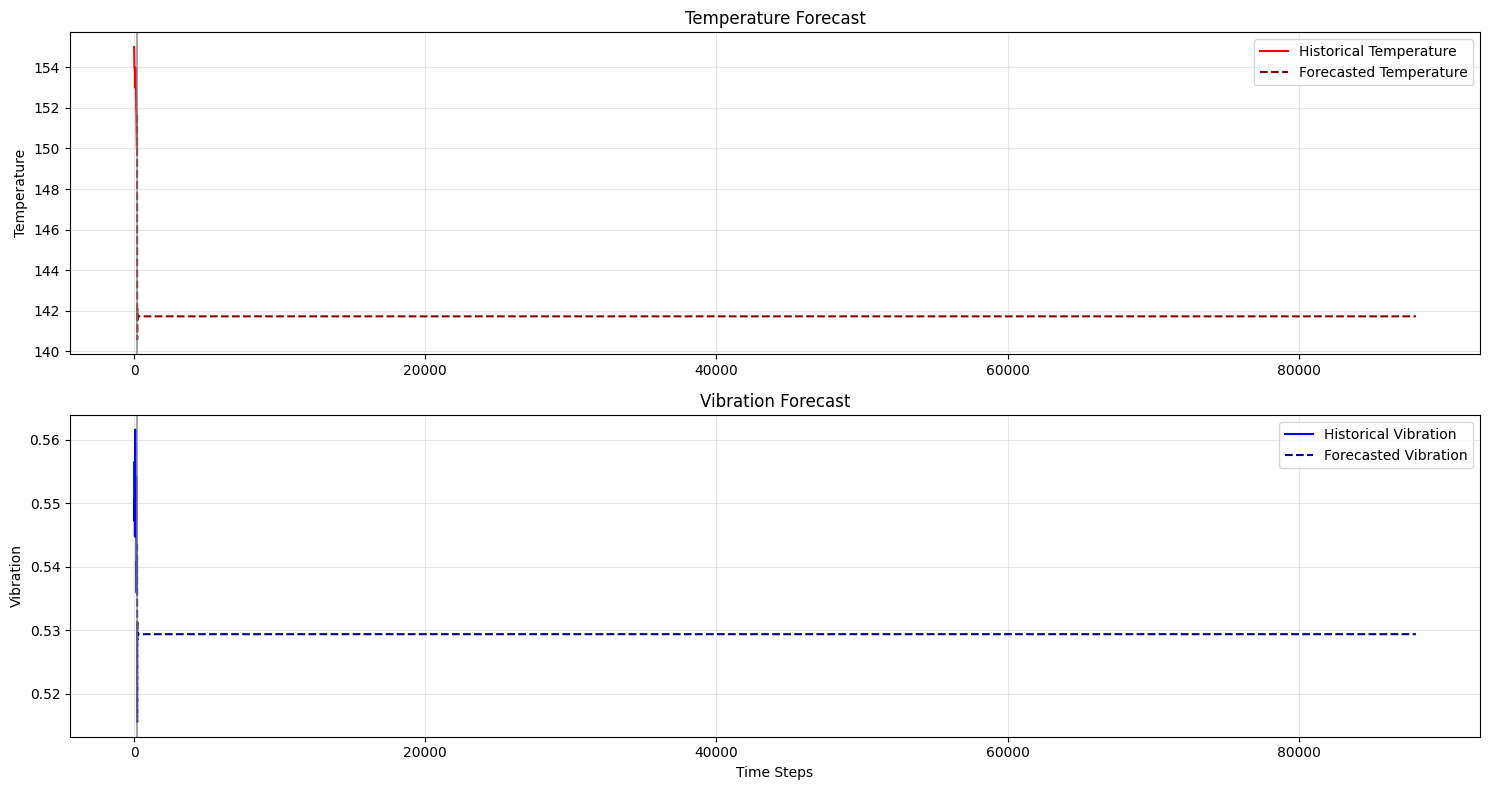

In [38]:
# =============================================================================
# 8. FUTURE FORECASTING
# =============================================================================

def forecast_future(model, last_sequence, n_steps, scaler, feature_indices):
    """
    Forecast future values
    """
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        # Predict next step
        next_pred = model.predict(current_sequence.reshape(1, SEQUENCE_LENGTH, -1), verbose=0)[0]
        future_predictions.append(next_pred)

        # Update sequence for next prediction
        new_row = current_sequence[-1].copy()

        # Update features (this is simplified - in practice you'd need to update all engineered features)
        new_row[feature_indices['temp_idx']] = next_pred[0]
        new_row[feature_indices['vib_idx']] = next_pred[1]

        current_sequence = np.vstack([current_sequence[1:], new_row])

    return np.array(future_predictions)

# Prepare for forecasting
last_sequence = scaled_data[-SEQUENCE_LENGTH:, :-2]  # Last sequence without targets

# Get feature indices (you would need to map these properly)
feature_indices = {
    'temp_idx': features_to_scale.index('Temperature') - 2,  # Adjust for target columns
    'vib_idx': features_to_scale.index('Vibration') - 2
}

# Forecast next 87.840 steps
n_future_steps = 87840
future_predictions = forecast_future(model, last_sequence, n_future_steps, scaler, feature_indices)

# Inverse transform predictions
dummy_array = np.zeros((n_future_steps, len(features_to_scale)))
dummy_array[:, -2] = future_predictions[:, 0]  # Temperature predictions
dummy_array[:, -1] = future_predictions[:, 1]   # Vibration predictions

future_predictions_inv = scaler.inverse_transform(dummy_array)[:, -2:]

print("Future Predictions Sample (first 10 steps):")
future_df = pd.DataFrame({
    'Predicted_Temperature': future_predictions_inv[:, 0],
    'Predicted_Vibration': future_predictions_inv[:, 1]
})
print(future_df.head(10))

# Plot future forecasts
plt.figure(figsize=(15, 8))

# Temperature forecast
plt.subplot(2, 1, 1)
historical_temp = df['Temperature'].values[-200:]  # Last 200 points
future_temp = future_predictions_inv[:, 0]

plt.plot(range(len(historical_temp)), historical_temp, label='Historical Temperature', color='red')
plt.plot(range(len(historical_temp), len(historical_temp) + len(future_temp)),
         future_temp, label='Forecasted Temperature', color='darkred', linestyle='--')
plt.axvline(x=len(historical_temp), color='gray', linestyle='-', alpha=0.7)
plt.ylabel('Temperature')
plt.title('Temperature Forecast')
plt.legend()
plt.grid(True, alpha=0.3)

# Vibration forecast
plt.subplot(2, 1, 2)
historical_vib = df['Vibration'].values[-200:]
future_vib = future_predictions_inv[:, 1]

plt.plot(range(len(historical_vib)), historical_vib, label='Historical Vibration', color='blue')
plt.plot(range(len(historical_vib), len(historical_vib) + len(future_vib)),
         future_vib, label='Forecasted Vibration', color='darkblue', linestyle='--')
plt.axvline(x=len(historical_vib), color='gray', linestyle='-', alpha=0.7)
plt.ylabel('Vibration')
plt.xlabel('Time Steps')
plt.title('Vibration Forecast')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# =============================================================================
# 9. MODEL DEPLOYMENT PREPARATION
# =============================================================================

# Save the model
model.save('motor_sensor_lstm_model.h5')

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')

# Save feature names
feature_info = {
    'selected_features': selected_features,
    'sequence_length': SEQUENCE_LENGTH,
    'features_to_scale': features_to_scale
}

import json
with open('model_features.json', 'w') as f:
    json.dump(feature_info, f)

print("Model and preprocessing artifacts saved successfully!")
print(f"Final Model Performance Summary:")
print(f"Temperature R²: {temp_metrics[3]:.4f}")
print(f"Vibration R²: {vib_metrics[3]:.4f}")
print(f"Average MAE - Temperature: {temp_metrics[1]:.4f}")
print(f"Average MAE - Vibration: {vib_metrics[1]:.4f}")

# Create performance summary
performance_summary = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'R²'],
    'Temperature': [f"{temp_metrics[0]:.6f}", f"{temp_metrics[1]:.6f}",
                   f"{temp_metrics[2]:.6f}", f"{temp_metrics[3]:.4f}"],
    'Vibration': [f"{vib_metrics[0]:.6f}", f"{vib_metrics[1]:.6f}",
                 f"{vib_metrics[2]:.6f}", f"{vib_metrics[3]:.4f}"]
})

print("\nPerformance Summary:")
print(performance_summary)

Model and preprocessing artifacts saved successfully!
Final Model Performance Summary:
Temperature R²: 0.9846
Vibration R²: 0.9009
Average MAE - Temperature: 0.0054
Average MAE - Vibration: 0.0024

Performance Summary:
  Metric Temperature Vibration
0    MSE    0.000042  0.000014
1    MAE    0.005397  0.002426
2   RMSE    0.006499  0.003733
3     R²      0.9846    0.9009


In [43]:
# =============================================================================
# 10. MODEL OUTPUT
# =============================================================================

# Create a DataFrame for the forecasted results with the correct dates
last_historical_date = df.index.max()
forecast_start_date = last_historical_date + pd.Timedelta(minutes=1) # Assuming 1-minute intervals
forecast_dates = pd.date_range(start=forecast_start_date, periods=n_future_steps, freq='min')

forecast_results_df = pd.DataFrame({
    'Timestamp': forecast_dates,
    'Predicted_Temperature': future_predictions_inv[:, 0],
    'Predicted_Vibration': future_predictions_inv[:, 1]
})

print("All Future Predictions with Timestamp:")
display(forecast_results_df)

# Save the full DataFrame to a CSV file
csv_filename_full_forecast = 'full_forecast_results.csv'
forecast_results_df.to_csv(csv_filename_full_forecast, index=False)

print(f"\nFull forecast results saved to {csv_filename_full_forecast}")

# Provide a link to download the file
from google.colab import files
files.download(csv_filename_full_forecast)

All Future Predictions with Timestamp:


,Timestamp,Predicted_Temperature,Predicted_Vibration
0,2022-11-01 00:00:00,151.646633,0.543624
1,2022-11-01 00:01:00,151.088701,0.543364
2,2022-11-01 00:02:00,149.768386,0.541989
3,2022-11-01 00:03:00,147.785056,0.539163
4,2022-11-01 00:04:00,145.440781,0.535152
...,...,...,...
87835,2022-12-31 23:55:00,141.728094,0.529395
87836,2022-12-31 23:56:00,141.728094,0.529395
87837,2022-12-31 23:57:00,141.728094,0.529395
87838,2022-12-31 23:58:00,141.728094,0.529395



Full forecast results saved to full_forecast_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>